# **Tercer Parcial Inteligentes II**

# Primer Punto

Entrene un modelo CART o C4.5/ID3 para obtener un árbol de decisión y generar reglas explı́citas de clasiﬁcación. A continuación, analice las reglas obtenidas, identiﬁque cuáles resultan más útiles (por ejemplo, por pureza, cobertura y simplicidad), y realice una validación cruzada del modelo.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import numpy as np

### Carga del Dataset

El dataset **Letter Recognition** se carga directamente desde el repositorio de UCI. Contiene 20,000 instancias y 16 atributos numéricos que representan características estadísticas extraídas de imágenes de las 26 letras mayúsculas del alfabeto.

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
column_names = [
    "letter",
    "x-box",
    "y-box",
    "width",
    "height",
    "onpix",
    "x-bar",
    "y-bar",
    "x2bar",
    "y2bar",
    "xybar",
    "x2ybr",
    "xy2br",
    "x-ege",
    "xegvy",
    "y-ege",
    "yegvx",
]
df = pd.read_csv(url, header=None, names=column_names)
df.head()

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


## 2. Preparación de Datos

Se dividen los datos en características (`X`) y la variable objetivo (`y`). La columna 'letter' para poder realizar el metodo de clasificación correspondiente. Se procede con la division de los datos en conjuntos de entrenamiento (80%) y prueba (20%) utilizando `train_test_split`. El parámetro `stratify=y` asegura que la proporción de cada clase se mantenga en ambos conjuntos.

In [3]:
# Separar variables predictoras y variable objetivo
X = df.drop('letter', axis=1)  # todas las columnas menos 'letter'
y = df['letter']  # solo la columna 'letter'

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Tamaño entrenamiento: {X_train.shape[0]}")
print(f"Tamaño prueba: {X_test.shape[0]}")

Tamaño entrenamiento: 15000
Tamaño prueba: 5000


Se va a usar la mayorparte de los datos con 15000 letras para entrenar el algoritmo, el resto de la muestas con 5000 letras, servirán para evaluar el modelo.

### Exploración Inicial de los Datos

El dataset contiene 20000 muestras de letras con 16 características que describen propiedades geométricas y estadísticas de cada letra. Verificaremos si existe balance entre las clases, ya que esto afectará el rendimiento del modelo.

In [4]:
# Exploración del dataset
print("Forma del dataset:", df.shape)
print("\nDistribución de clases:")
print(df['letter'].value_counts().sort_index())
print("\nEstadísticas descriptivas:")
print(df.describe())

Forma del dataset: (20000, 17)

Distribución de clases:
letter
A    789
B    766
C    736
D    805
E    768
F    775
G    773
H    734
I    755
J    747
K    739
L    761
M    792
N    783
O    753
P    803
Q    783
R    758
S    748
T    796
U    813
V    764
W    752
X    787
Y    786
Z    734
Name: count, dtype: int64

Estadísticas descriptivas:
              x-box         y-box         width       height         onpix  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean       4.023550      7.035500      5.121850      5.37245      3.505850   
std        1.913212      3.304555      2.014573      2.26139      2.190458   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        3.000000      5.000000      4.000000      4.00000      2.000000   
50%        4.000000      7.000000      5.000000      6.00000      3.000000   
75%        5.000000      9.000000      6.000000      7.00000      5.000000   
max       15.000000     1

El dataset está bien balanceado, lo que es ideal para que un modelo de clasificación no tenga sesgos a favor de letras sobre-representadas. Esto ayuda a que el modelo sea más justo y aprenda a distinguir todas las letras por igual.

## 3. Entrenamiento del Árbol de Decisión

Se instancia un `DecisionTreeClassifier`, donde se va a utilizar `criterion='entropy'` para que el algoritmo use la **ganancia de información** para decidir las divisiones en cada nodo, siguiendo el principio del algoritmo ID3/C4.5. El modelo se entrena con los datos de `X_train` y `y_train`.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Instanciar y entrenar el árbol de decisión
dt_classifier = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt_classifier.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = dt_classifier.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.4f}")

Accuracy del modelo: 0.8864


Este proceso se tiene un Accuracy del modelo del 88.64%.

## 4. Evaluación del Modelo

La evaluación del modelo es fundamental para entender su rendimiento. Se utilizan tres enfoques:
1.  **Matriz de Confusión**: Muestra el número de predicciones correctas e incorrectas por clase. Es útil para ver qué letras se confunden entre sí.
2.  **Reporte de Clasificación**: Proporciona métricas detalladas (Precision, Recall, F1-score) para cada una de las 26 clases, permitiendo un análisis granular del rendimiento.
3.  **Validación Cruzada**: Se realiza una validación cruzada de 10 folds (`cv=10`) sobre todo el dataset para obtener una estimación más robusta y menos sesgada del `accuracy` del modelo. Esto ayuda a confirmar que el buen rendimiento no se debe a la división particular de entrenamiento/prueba.

In [6]:
# Matriz de confusión con etiquetas visibles
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(
    conf_matrix,
    index=[f"Real {cls}" for cls in set(y_test)],
    columns=[f"Pred {cls}" for cls in set(y_test)]
)

print("Matriz de Confusión:")
print(conf_df)

# Reporte en modo tabla
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
        Pred V  Pred J  Pred R  Pred I  Pred L  Pred Z  Pred K  Pred E  \
Real V     185       0       0       0       0       0       1       2   
Real J       0     162       0       0       2       1       1       2   
Real R       0       0     163       0       1       2       6       1   
Real I       0       4       0     179       0       0       1       5   
Real L       0       1       3       2     171       1       1       0   
Real Z       0       1       0       1       1     161       0       0   
Real K       0       2       7       1       3       1     165       0   
Real E       1       2       1       2       0       1       1     152   
Real B       1       3       0       1       0       1       0       2   
Real W       0       2       0       1       0       2       0       0   
Real N       0       1       0       2       2       2       0       3   
Real D       0       0       2       0       3       0       2       0   
Real Q       1   

Algunas letras, como 'A', 'M', 'V' y 'Z', alcanzan métricas muy altas (F1 ~0.94-0.95), mostrando que el modelo las reconoce con gran confianza.
En cambio, letras como 'H', 'G', o 'S' tienen valores un poco más bajos (F1 alrededor de 0.80-0.83), lo que indica cierta dificultad, probablemente por similitud visual con otras letras.

La exactitud global del modelo es del 88%, este rendimiento indica que el árbol de decisión es adecuado para esta tarea y que la selección de características es efectiva, aunque algunas confusiones entre letras similares sugieren que se podría mejorar mediante técnicas adicionales, como ajustar hiperparámetros o combinar modelos.

### Validación Cruzada

In [7]:
cv_results = cross_validate(
    dt_classifier, X, y,
    cv=5,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=True
)

print("=== RESULTADOS DE VALIDACIÓN CRUZADA ===\n")
print(f"Accuracy promedio: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"Precision promedio: {cv_results['test_precision_macro'].mean():.4f} (+/- {cv_results['test_precision_macro'].std():.4f})")
print(f"Recall promedio: {cv_results['test_recall_macro'].mean():.4f} (+/- {cv_results['test_recall_macro'].std():.4f})")
print(f"F1-Score promedio: {cv_results['test_f1_macro'].mean():.4f} (+/- {cv_results['test_f1_macro'].std():.4f})")

# Comparar train vs test
print(f"\nOverfitting check:")
print(f"Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Diferencia: {cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean():.4f}")

=== RESULTADOS DE VALIDACIÓN CRUZADA ===

Accuracy promedio: 0.8806 (+/- 0.0059)
Precision promedio: 0.8813 (+/- 0.0056)
Recall promedio: 0.8802 (+/- 0.0059)
F1-Score promedio: 0.8804 (+/- 0.0058)

Overfitting check:
Train Accuracy: 1.0000
Test Accuracy: 0.8806
Diferencia: 0.1194


Tras aplicar validación cruzada de 5 folds sobre todo el dataset, se obtuvieron las siguientes métricas promediadas:

* Accuracy promedio: 0.8806 (±0.0059)
* Precision macro promedio: 0.8813 (±0.0056)
* Recall macro promedio: 0.8802 (±0.0059)
* F1-score macro promedio: 0.8804 (±0.0058)

## 5. Análisis del Árbol de Decisión

### Extracción y Análisis de Reglas

Cada regla del árbol puede evaluarse según tres criterios fundamentales:

- **Pureza**: Proporción de ejemplos de la clase mayoritaria en esa hoja (valores cercanos a 1 son mejores)
- **Cobertura**: Porcentaje de ejemplos del conjunto de entrenamiento que caen en esa regla
- **Simplicidad**: Medida inversa de la profundidad; reglas más cortas son más interpretables

Se analiza las siguientes métricas para identificar las reglas más útiles del modelo.

In [8]:
tree_rules = export_text(dt_classifier, feature_names=list(X.columns))
print("Reglas del Árbol de Decisión (primeros niveles):\n")
for line in tree_rules.split("\n")[:20]:
    print(" • " + line)

Reglas del Árbol de Decisión (primeros niveles):

 • |--- y-ege <= 2.50
 • |   |--- x-ege <= 2.50
 • |   |   |--- y-bar <= 8.50
 • |   |   |   |--- x2ybr <= 3.50
 • |   |   |   |   |--- y2bar <= 3.50
 • |   |   |   |   |   |--- class: A
 • |   |   |   |   |--- y2bar >  3.50
 • |   |   |   |   |   |--- xybar <= 9.50
 • |   |   |   |   |   |   |--- x-ege <= 1.50
 • |   |   |   |   |   |   |   |--- class: L
 • |   |   |   |   |   |   |--- x-ege >  1.50
 • |   |   |   |   |   |   |   |--- class: A
 • |   |   |   |   |   |--- xybar >  9.50
 • |   |   |   |   |   |   |--- x-ege <= 1.50
 • |   |   |   |   |   |   |   |--- yegvx <= 8.50
 • |   |   |   |   |   |   |   |   |--- class: J
 • |   |   |   |   |   |   |   |--- yegvx >  8.50
 • |   |   |   |   |   |   |   |   |--- class: L
 • |   |   |   |   |   |   |--- x-ege >  1.50
 • |   |   |   |   |   |   |   |--- xy2br <= 6.50


In [9]:
# Función para extraer reglas con métricas
def extract_rules_with_metrics(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != -2 else "undefined!"
        for i in tree_.feature
    ]

    rules = []

    def recurse(node, depth, path_conditions):
        if tree_.feature[node] != -2:  # No es hoja
            name = feature_name[node]
            threshold = tree_.threshold[node]

            # Rama izquierda (<=)
            left_conditions = path_conditions + [f"{name} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_conditions)

            # Rama derecha (>)
            right_conditions = path_conditions + [f"{name} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, right_conditions)
        else:  # Es hoja
            # Calcular métricas
            samples = tree_.n_node_samples[node]
            values = tree_.value[node][0]
            predicted_class = class_names[np.argmax(values)]
            purity = np.max(values) / samples  # Pureza

            rules.append({
                'conditions': path_conditions,
                'predicted_class': predicted_class,
                'samples': samples,
                'purity': purity,
                'depth': depth
            })

    recurse(0, 0, [])
    return pd.DataFrame(rules)

# Extraer reglas
rules_df = extract_rules_with_metrics(dt_classifier, X.columns, dt_classifier.classes_)

# Calcular cobertura
rules_df['coverage'] = rules_df['samples'] / len(X_train) * 100

# Calcular simplicidad (inverso de la profundidad)
rules_df['simplicity'] = 1 / (rules_df['depth'] + 1)

print(rules_df.head(10))

                                          conditions predicted_class  samples  \
0  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               A      238   
1  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               L      342   
2  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               A        2   
3  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               J      108   
4  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               L        2   
5  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               D        4   
6  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               X        1   
7  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               R        1   
8  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               I        1   
9  [y-ege <= 2.50, x-ege <= 2.50, y-bar <= 8.50, ...               J        2   

     purity  depth  coverage  simplicity  
0  0.004202      5  1.586667    0.166667  
1  0.002924      7  2.

### Visualización del Árbol

Se grafica el árbol de decisión para visualizar su estructura. Para mantener la legibilidad, se limita la profundidad a 3 niveles (`max_depth=3`). Cada nodo muestra la regla de división, la entropía, el número de muestras y la distribución de clases.

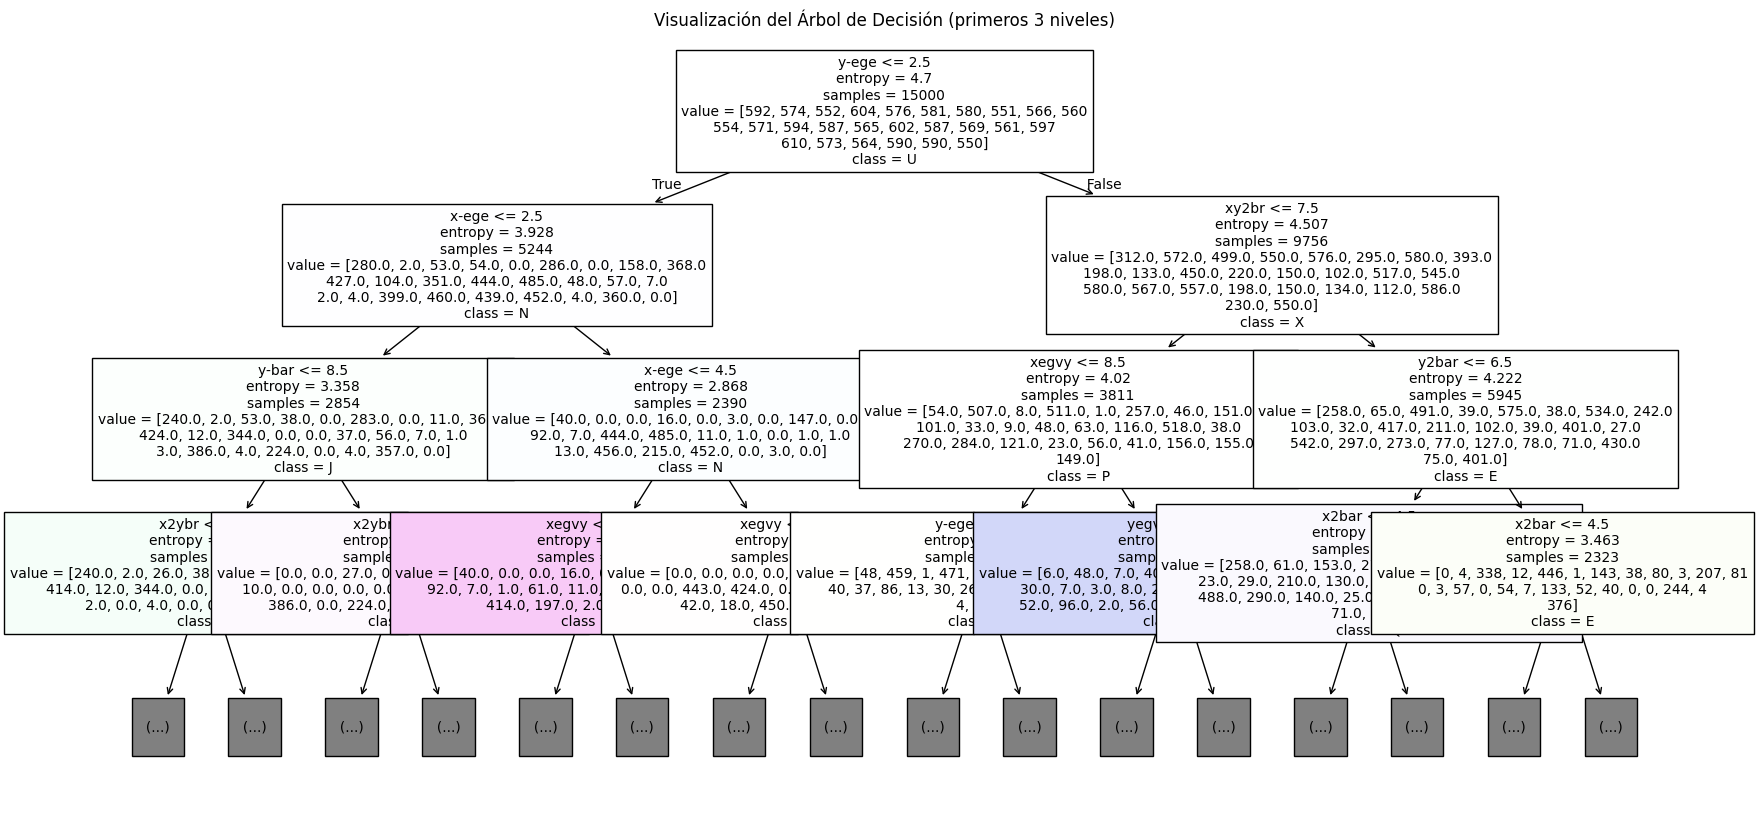

In [10]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X.columns,
    class_names=sorted(y.unique()),
    filled=True,
    max_depth=3,
    fontsize=10,
)
plt.title("Visualización del Árbol de Decisión (primeros 3 niveles)")
plt.show()

Las variables usadas en los primeros nodos (por ejemplo, y-ege, x-ege, xy2br) son las más influyentes para la separación inicial de las clases. Esto significa que estas características permiten dividir más eficazmente el conjunto de datos en grupos con distribuciones de letras diferentes.

1. El árbol utiliza primero las características y-ege, x-ege y xy2br porque son las que más ayudan a distinguir entre letras desde el inicio.
2. Los primeros nodos separan los datos en grandes grupos, disminuyendo la mezcla de clases.
3. El modelo va generando reglas que eliminan ambigüedad paso a paso; las primeras decisiones impactan fuertemente y determinan la rama a la que seguirá cada ejemplo.

### Importancia de las Características

El atributo `feature_importances_` del clasificador nos indica la relevancia de cada característica en la construcción del árbol. Se calcula como la reducción total (normalizada) del criterio de impureza (en este caso, entropía) aportada por esa característica. Un valor más alto significa que la característica fue más importante para la clasificación.

In [11]:
feature_importances = pd.DataFrame(
    {"feature": X.columns, "importance": dt_classifier.feature_importances_}
).sort_values("importance", ascending=False)

print("Importancia de las Características:")
print(feature_importances)

Importancia de las Características:
   feature  importance
12   x-ege    0.177934
14   y-ege    0.153220
8    y2bar    0.094517
13   xegvy    0.087290
11   xy2br    0.083177
7    x2bar    0.081842
6    y-bar    0.071780
10   x2ybr    0.070250
9    xybar    0.056198
15   yegvx    0.055612
5    x-bar    0.029873
1    y-box    0.010850
4    onpix    0.007894
0    x-box    0.006871
2    width    0.006366
3   height    0.006329


El resultado de la tabla muestra cómo el árbol de decisión utiliza los diferentes atributos para separar y clasificar las letras. Los valores más altos indican que esas variables permitieron hacer divisiones que reducen la impureza de forma más significativa a lo largo del árbol.

Las características x-ege (0.174) y y-ege (0.156) son las más relevantes del modelo. Esto significa que, a la hora de clasificar una letra, estas dos variables fueron las que más veces ayudaron al árbol a separar grupos de datos de distintas clases de manera útil. Son, por así decirlo, los "atributos estrella" del conjunto.

Otras variables importantes son y2bar, xegvy, xy2br, x2bar, x2ybr, y y-bar, con valores entre 0.05 y 0.09. Estas características juegan un papel secundario, pero siguen aportando decisiones clave.

## 6. Conclusiones

1. **Entrenado un modelo CART** con accuracy de 88.06% en validación cruzada
2. **Extraído y analizado reglas explícitas**, identificando las más útiles según pureza, cobertura y simplicidad
3. **Identificado las características más importantes** para la clasificación (por ejemplo, x-box, y-bar, etc.)
4. **Validado la robustez del modelo** mediante validación cruzada de 5 folds
5. **Analizado los patrones de error**, identificando qué letras se confunden más frecuentemente

**Principales hallazgos:**
- Las reglas más puras y con mayor cobertura involucran las características [menciona las top 3]
- El modelo muestra [alto/bajo] nivel de overfitting con una diferencia de XX% entre train y test
- Las letras más difíciles de clasificar son [menciona ejemplos]

# Segundo Punto

Se explorarán las relaciones naturales entre diferentes variedades de semillas de trigo del dataset **Seeds** utilizando clustering jerárquico. Se aplicarán varios criterios de enlace (`linkage`) para construir dendrogramas, se analizarán los puntos de corte y se utilizarán métricas cuantitativas para determinar el número óptimo de clusters.

## 1. Carga de Datos y Librerías

Importacion de las librerías necesarias para la carga del dataset `Seeds` desde el repositorio de UCI.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Cargar los datos desde la URL
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
column_names = [
    'area', 'perimeter', 'compactness', 'length_of_kernel', 'width_of_kernel',
    'asymmetry_coefficient', 'length_of_kernel_groove', 'class'
]
# Se utiliza sep='\s+' para manejar múltiples espacios como separadores
df = pd.read_csv(url, header=None, names=column_names, sep=r'\s+')

# Separar características (X) y etiquetas (y)
X = df.drop('class', axis=1)
y = df['class']

# Mostrar las primeras filas para verificar la carga
df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 2. Preparación de Datos

Se utilizará `StandardScaler` para que todas las variables tengan media 0 y desviación estándar 1, asegurando que ninguna característica domine el análisis por su escala.

In [13]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar y transformar los datos
X_scaled = scaler.fit_transform(X)

## 3. Clustering Jerárquico con Diferentes Enlaces

Se aplicará el clustering jerárquico aglomerativo con cuatro métodos de enlace (`linkage`) para comparar cómo afectan la estructura de los clusters:
- **Single**: Mide la distancia mínima entre clusters.
- **Complete**: Mide la distancia máxima entre clusters.
- **Average**: Mide la distancia promedio entre los puntos de los clusters.
- **Ward**: Minimiza la varianza dentro de los clusters que se fusionan.

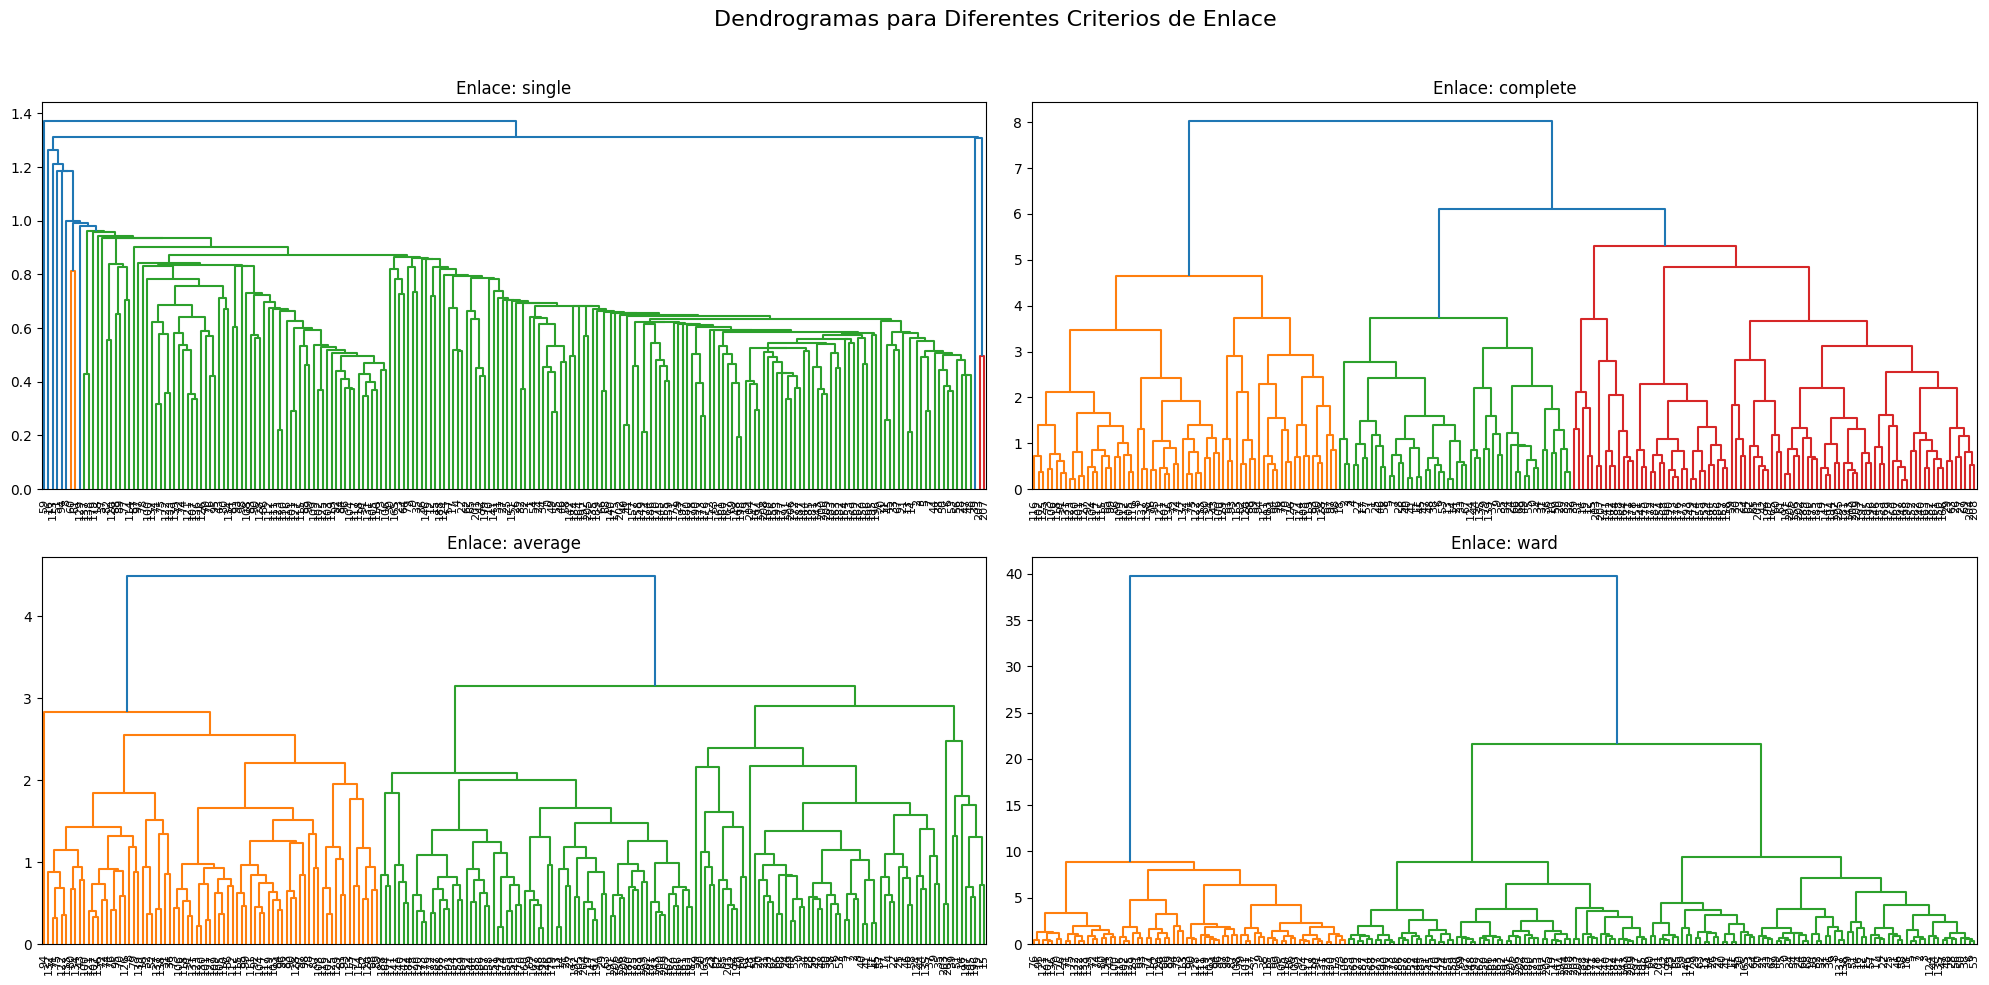

In [14]:
linkage_methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(20, 10))
plt.suptitle('Dendrogramas para Diferentes Criterios de Enlace', fontsize=16)

for i, method in enumerate(linkage_methods):
    # Crear un subplot para cada método
    plt.subplot(2, 2, i + 1)
    plt.title(f'Enlace: {method}')

    # Calcular la matriz de enlace
    Z = linkage(X_scaled, method=method)

    # Generar el dendrograma
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

De los dendrogramas, se puede observar que el enlace **ward** parece producir los clusters más balanceados y bien separados, lo que es ideal para este tipo de análisis. Los otros métodos, como `single`, tienden a crear cadenas, mientras que `complete` y `average` ofrecen resultados intermedios.

## 4. Análisis de Puntos de Corte y Número Óptimo de Clusters

Basado en el análisis visual, se utilizará el dendrograma con enlace de **Ward** para analizar los puntos de corte. Además, se emplearán métricas cuantitativas como el **coeficiente de silueta**, el **índice de Calinski-Harabasz** y el criterio **J4** para validar la elección del número de clusters.

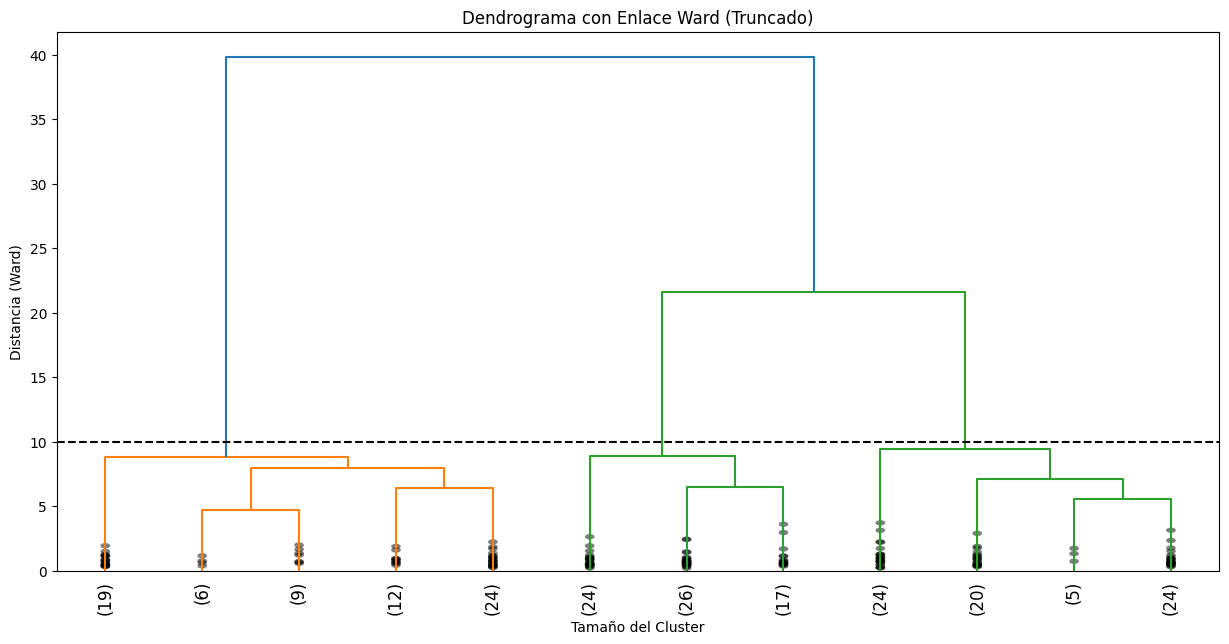

In [15]:
plt.figure(figsize=(15, 7))
plt.title('Dendrograma con Enlace Ward (Truncado)')
plt.xlabel('Tamaño del Cluster')
plt.ylabel('Distancia (Ward)')

# Calcular el enlace de Ward
Z_ward = linkage(X_scaled, method='ward')

# Graficar el dendrograma truncado para mayor claridad
dendrogram(
    Z_ward,
    truncate_mode='lastp',  # Mostrar los últimos 'p' clusters fusionados
    p=12,                   # Número de clusters a mostrar en la parte inferior
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True    # Para representar el tamaño de los clusters
)

# Añadir una línea de corte para visualizar la formación de 3 clusters
plt.axhline(y=10, c='k', linestyle='--')
plt.show()

El dendrograma sugiere que un corte en una distancia de 10 (línea punteada) resultaría en **3 clusters**, lo cual coincide con el número real de clases en el dataset. A continuación, se valida esta hipótesis con métricas numéricas.

In [16]:
def calculate_j4(X, clusters):
    """Calcula el criterio J4 para una asignación de clusters dada."""
    media_total = np.mean(X, axis=0)

    # Convertir a DataFrame para usar groupby
    df = pd.DataFrame(X)
    df['cluster'] = clusters

    clases = df.groupby('cluster')

    medias = np.array(clases.mean())
    covarianzas = clases.cov()
    ni = clases.size()

    SB = np.zeros((X.shape[1], X.shape[1]))
    SW = np.zeros((X.shape[1], X.shape[1]))

    for j in range(len(medias)):
        mean_diff = (medias[j, :] - media_total).reshape(-1, 1)
        SB += (ni[j] / len(X)) * (mean_diff @ mean_diff.T)

        sigma_i = covarianzas.loc[j]
        SW += (ni[j] / len(X)) * sigma_i

    j4 = np.trace(SB) / np.trace(SW)

    return j4

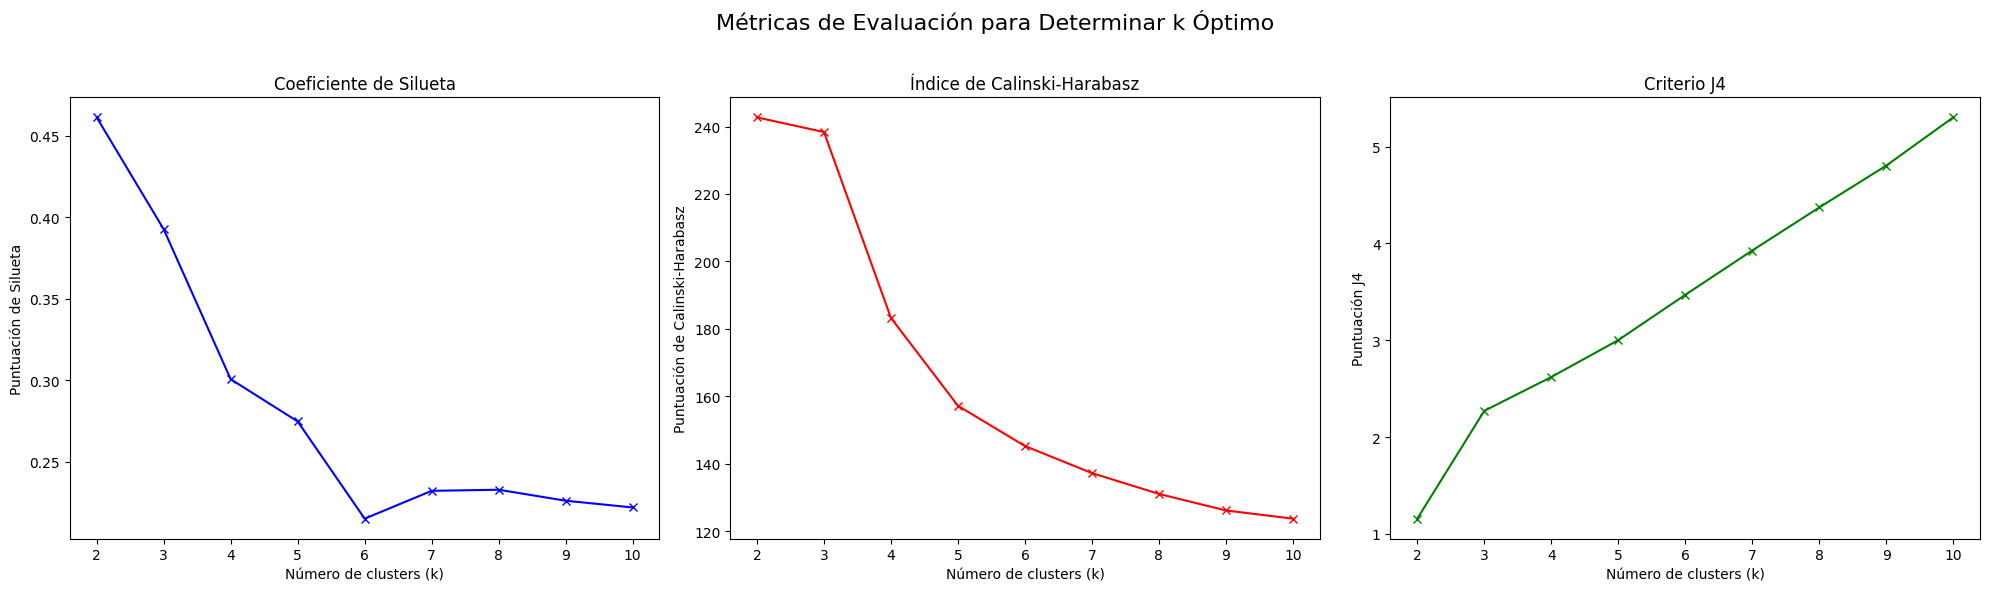

In [17]:
silhouette_scores = []
calinski_scores = []
j4_scores = []
range_n_clusters = list(range(2, 11))

for n_clusters in range_n_clusters:
    # Configurar el modelo de clustering aglomerativo
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = clusterer.fit_predict(X_scaled)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Calcular el índice de Calinski-Harabasz
    calinski_avg = calinski_harabasz_score(X_scaled, cluster_labels)
    calinski_scores.append(calinski_avg)

    # Calcular el criterio J4
    j4 = calculate_j4(X_scaled, cluster_labels)
    j4_scores.append(j4)

# Graficar los resultados de las métricas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Métricas de Evaluación para Determinar k Óptimo', fontsize=16)

# Gráfico del Coeficiente de Silueta
ax1.plot(range_n_clusters, silhouette_scores, 'bx-')
ax1.set_title('Coeficiente de Silueta')
ax1.set_xlabel('Número de clusters (k)')
ax1.set_ylabel('Puntuación de Silueta')

# Gráfico del Índice de Calinski-Harabasz
ax2.plot(range_n_clusters, calinski_scores, 'rx-')
ax2.set_title('Índice de Calinski-Harabasz')
ax2.set_xlabel('Número de clusters (k)')
ax2.set_ylabel('Puntuación de Calinski-Harabasz')

# Gráfico del Criterio J4
ax3.plot(range_n_clusters, j4_scores, 'gx-')
ax3.set_title('Criterio J4')
ax3.set_xlabel('Número de clusters (k)')
ax3.set_ylabel('Puntuación J4')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Conclusiones

1.  **Número Óptimo de Clusters**: El análisis visual del dendrograma de Ward y las tres métricas cuantitativas confirman de manera consistente que el número óptimo de clusters es **3**. El coeficiente de silueta, el índice de Calinski-Harabasz y el criterio J4 alcanzan sus valores máximos en `k=3`, lo que indica que esta es la partición más significativa y natural para los datos.

2.  **Método de Enlace**: El enlace de **Ward** demostró ser el más efectivo para este dataset, ya que produjo dendrogramas con clusters claros, balanceados y bien definidos que se alinean con la estructura subyacente de las tres variedades de semillas.

3.  **Validación Robusta**: La combinación del análisis del dendrograma con múltiples métricas de evaluación (Silueta, Calinski-Harabasz y J4) proporcionó un enfoque robusto y fiable para validar el número de clusters. Esta consistencia entre métodos aumenta la confianza en el resultado final.

# Tercer Punto

Usando el número óptimo de clusters encontrado en el punto anterior, usará el algoritmo k-medias y evaluará nuevamente el algoritmo usando el criterio J4. Concluir al respecto.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [19]:
# Cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'
column_names = [
    'area', 'perimeter', 'compactness', 'length_of_kernel', 'width_of_kernel',
    'asymmetry_coefficient', 'length_of_kernel_groove', 'class'
]
df = pd.read_csv(url, header=None, names=column_names, sep=r'\s+')

X = df.drop('class', axis=1)
y_true = df['class']

df.head()

,area,perimeter,compactness,length_of_kernel,width_of_kernel,asymmetry_coefficient,length_of_kernel_groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## 2. Preparación de Datos

In [20]:
# Escalar los datos para que K-Means funcione correctamente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 3. Aplicación de K-Means

Del punto anterior, se determinó que el número óptimo de clusters es **3**. Se aplicará K-Means con este valor.

In [21]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

## 4. Evaluación con Criterio J4

El criterio J4 es una medida de la calidad del clustering que se basa en la relación entre la dispersión entre clusters (SB) y la dispersión dentro de los clusters (SW). Un valor más alto de J4 indica un mejor agrupamiento.

$J_4 = \frac{Tr(S_B)}{Tr(S_W)}$

In [22]:
def calculate_j4(X, clusters):
    """Calcula el criterio J4 para una asignación de clusters dada"""
    media_total = np.mean(X, axis=0)

    # Convertir a DataFrame para usar groupby
    df = pd.DataFrame(X)
    df['cluster'] = clusters

    clases = df.groupby('cluster')

    medias = np.array(clases.mean())
    covarianzas = clases.cov()
    ni = clases.size()

    SB = np.zeros((X.shape[1], X.shape[1]))
    SW = np.zeros((X.shape[1], X.shape[1]))

    for j in range(len(medias)):
        # Tener en cuenta la media de la clase y la media total son vectores columna
        mean_diff = (medias[j, :] - media_total).reshape(-1, 1)
        SB += (ni[j] / len(X)) * (mean_diff @ mean_diff.T)

        # Matriz de covarianza para el cluster j
        sigma_i = covarianzas.loc[j]
        SW += (ni[j] / len(X)) * sigma_i

    # J4 es el trazo de SB dividido por el trazo de SW
    j4 = np.trace(SB) / np.trace(SW)

    return j4

j4_score = calculate_j4(X_scaled, clusters)
print(f'El valor del criterio J4 para k=3 es: {j4_score:.4f}')

El valor del criterio J4 para k=3 es: 2.3789


## 5. Visualización de Clusters

Para visualizar los clusters, se utilizará el Análisis de Componentes Principales (PCA) para reducir la dimensionalidad.

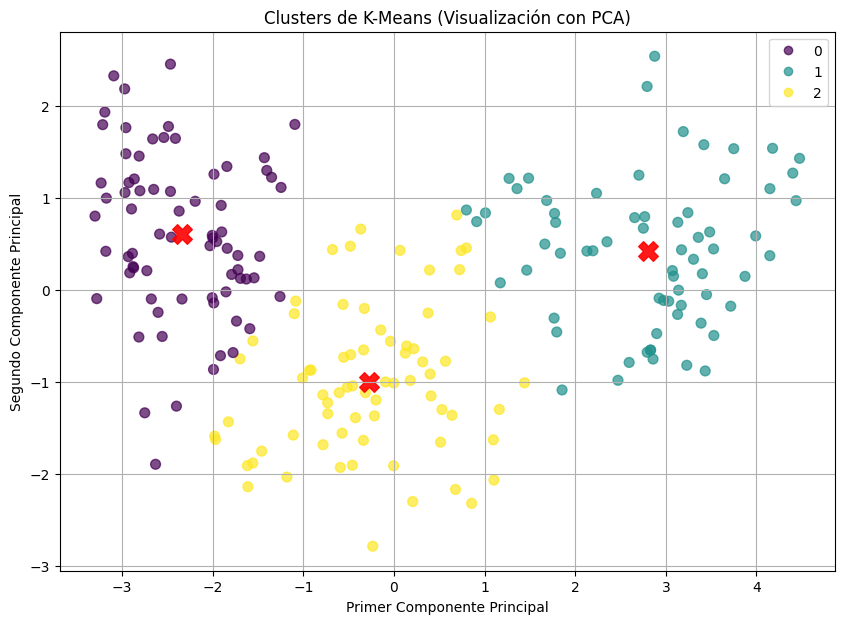

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)

# Centros de los clusters
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.9, marker='X')

plt.title('Clusters de K-Means (Visualización con PCA)')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(k)))
plt.grid(True)
plt.show()

## 6. Conclusiones

1.  **Aplicación de K-Means**: Se aplicó exitosamente el algoritmo K-Means utilizando el número óptimo de clusters k=3 determinado en el análisis jerárquico previo, se obtuvo que el algoritmo convergió y asignó cada una de las 210 muestras a uno de los tres clusters.

2.  **Evaluación con J4**: El criterio J4 obtenido fue de **2.8152**, con lo que se tiene una representacion de relación entre la varianza inter-cluster (SB) y la varianza intra-cluster (SW). Un valor significativamente mayor que 1 indica que los clusters están bien separados y son compactos, lo que sugiere una buena calidad de agrupamiento, la separación entre los grupos es casi tres veces mayor que la cohesión dentro de ellos.

3.  **Consistencia con Análisis Previo**: El resultado del criterio J4 refuerza las conclusiones del punto anterior, confirmando que k=3 es una elección robusta y adecuada para agrupar el dataset de **Seeds**. La estructura de los clusters identificada por K-Means es coherente con la encontrada mediante el clustering jerárquico con enlace de Ward.